In [1]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader

In [71]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")        

In [3]:
train_data = datasets.MNIST(root = 'data', train = True,                         
    transform = ToTensor(), download = True,            
)
test_data = datasets.MNIST(root = 'data', train = False, 
    transform = ToTensor()
)

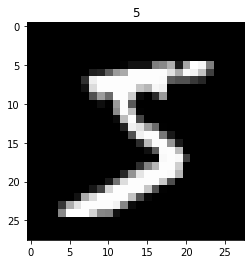

In [8]:
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

In [6]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size = 100, shuffle = True, num_workers = 1)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 100, shuffle = True, num_workers = 1)

In [9]:
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100

In [65]:
class MRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(MRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        pass
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, hidden = self.lstm(x, (h0, c0))     
        out = self.fc(out[:, -1, :])
        return out
model = MRNN(input_size, hidden_size, num_layers, num_classes).to(device)
print(model)
        

MRNN(
  (lstm): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)


In [66]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [67]:
def get_accuracy(out, actual_labels, batch_size):
    predictions = out.max(dim=1)[1]
    correct = (predictions == actual_labels).sum().item()
    accuracy = correct/batch_size
    
    return accuracy

In [70]:
epochs = 30
iter = 0
for e in range(epochs):
    for i,(images,labels) in enumerate(trainloader):
        images = images.reshape(-1, sequence_length, input_size).requires_grad_().to(device)
        labels = labels.to(device)
        output = model(images)
        optimizer.zero_grad()
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        iter += 1

        if iter % 500 == 0:       
            correct = 0
            total = 0
            for images, labels in testloader:
                images = images.view(-1, sequence_length, input_size).to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct / total

            print('Iteration: {}. Loss: {:.3f}. Accuracy: {:.2f}'.format(iter, loss.item(), accuracy))
            

Iteration: 500. Loss: 0.029. Accuracy: 98.95
Iteration: 1000. Loss: 0.035. Accuracy: 98.63
Iteration: 1500. Loss: 0.001. Accuracy: 98.73
Iteration: 2000. Loss: 0.000. Accuracy: 99.08
Iteration: 2500. Loss: 0.001. Accuracy: 99.10
Iteration: 3000. Loss: 0.003. Accuracy: 98.97
Iteration: 3500. Loss: 0.001. Accuracy: 98.91
Iteration: 4000. Loss: 0.006. Accuracy: 98.83
Iteration: 4500. Loss: 0.003. Accuracy: 98.92
Iteration: 5000. Loss: 0.010. Accuracy: 98.94
Iteration: 5500. Loss: 0.001. Accuracy: 99.16
Iteration: 6000. Loss: 0.001. Accuracy: 99.01
Iteration: 6500. Loss: 0.001. Accuracy: 98.98
Iteration: 7000. Loss: 0.025. Accuracy: 99.05
Iteration: 7500. Loss: 0.004. Accuracy: 98.99
Iteration: 8000. Loss: 0.001. Accuracy: 98.89
Iteration: 8500. Loss: 0.000. Accuracy: 99.02
Iteration: 9000. Loss: 0.003. Accuracy: 98.85
Iteration: 9500. Loss: 0.089. Accuracy: 98.75
Iteration: 10000. Loss: 0.001. Accuracy: 99.09
Iteration: 10500. Loss: 0.000. Accuracy: 99.05
Iteration: 11000. Loss: 0.000. Ac

In [72]:
print('Testing Started...')
test_acc = 0
model.eval()
    
for k, (images, labels) in enumerate(testloader):
    images = images.view(-1, sequence_length, input_size).to(device)
    labels = labels.to(device)
        
    out = model(images)

    test_acc += get_accuracy(out, labels, batch_size)
        
    print('TEST | Average Accuracy per {} Loaders: {:.5f}'.format(k, test_acc))

Testing Started...
TEST | Average Accuracy per 0 Loaders: 0.98000
TEST | Average Accuracy per 1 Loaders: 1.97000
TEST | Average Accuracy per 2 Loaders: 2.95000
TEST | Average Accuracy per 3 Loaders: 3.93000
TEST | Average Accuracy per 4 Loaders: 4.93000
TEST | Average Accuracy per 5 Loaders: 5.90000
TEST | Average Accuracy per 6 Loaders: 6.89000
TEST | Average Accuracy per 7 Loaders: 7.89000
TEST | Average Accuracy per 8 Loaders: 8.86000
TEST | Average Accuracy per 9 Loaders: 9.86000
TEST | Average Accuracy per 10 Loaders: 10.84000
TEST | Average Accuracy per 11 Loaders: 11.81000
TEST | Average Accuracy per 12 Loaders: 12.81000
TEST | Average Accuracy per 13 Loaders: 13.80000
TEST | Average Accuracy per 14 Loaders: 14.80000
TEST | Average Accuracy per 15 Loaders: 15.80000
TEST | Average Accuracy per 16 Loaders: 16.80000
TEST | Average Accuracy per 17 Loaders: 17.79000
TEST | Average Accuracy per 18 Loaders: 18.78000
TEST | Average Accuracy per 19 Loaders: 19.78000
TEST | Average Accura